# BERT Model with PyTorch


# 1. Setup

## 1.1. Installing the Hugging Face Library



Install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face it will provide pytorch interface for BERT.

Hugging face library is the widely accepted pytorch BERT interfance, provide support for various pre-trained transformer model.

In [1]:
#!pip install transformers==3

In [2]:
#!pip install mlxtend

## 1.2. Import Libraries



We will import Relevant libraries which will be use for our porject.

In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import copy
import numpy as np
import transformers
from tqdm import tqdm
from transformers import BertTokenizer
from transformers import AdamW, BertConfig
import torch.nn as nn
from pathlib import Path
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn import model_selection
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import random
%matplotlib inline
sns.set_style('whitegrid')

In [4]:
# for ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

## 1.3 Checking Device
Set the Device to GPU or CPU.

In [6]:
# Check If the a GPU is available
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    
    print('GPU is not available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.


## 1.4 Define Parameters

In [7]:
MAX_LENGTH = 150
TRAIN_BATCH_SIZE = 15
VALID_BATCH_SIZE = 20
# Number of training epochs ( Hugging Face recommend between 2 and 4)
N_EPOCHS = 3
models_path = './models/'
model_name = 'Bert_Model_HS_2.pth'

# 2. Dataset


The dataset used for this project contains 24,784 tweets manually labeled by CrowdFlower users as as hate_speech, offensive_language, or neither.

## 2.1. Introduction of Dataset

**Format**

1. index: the unique identifier of the tweet

2. count: the total # of CrowdFlower users who labeled the tweet

3. hate_speech: the # of CrowdFlower users who labeled the tweet as containing or constituting hate speech

4. offensive_language: the # of CrowdFlower users who labeled the tweet as containing or constituting offensive language

5. neither: the # of CrowdFlower users who labeled the Tweet as neither hate speech nor offensive language

6. class: the majority label given by CrowdFlower users (0 represents hate speech, 1 represents offensive language, and 2 represents neither)

7. tweet: the tweet, in textual form

8. clean_tweet: the text of the tweet after removing punctuation and converting to lower-case

**Reference**: [here](https://github.com/aman-saha/hate-speech-detection/tree/master/initial%20datasets)

## 2.2. Parse

Pandas is a powerful environment for parsing. We are using pandas to extract data from the csv and perform operations.

In [8]:
import pandas as pd

# Load the dataset into a pandas dataframe.
train_df = pd.read_csv("./Hate Speech Dataset/cleaned_tweets.csv")

print('Number of tweets for training: {:,}\n'.format(train_df.shape[0]))

# Display top 10 tweets
train_df.head(10)

Number of tweets for training: 24,783



,index,count,hate_speech,offensive_language,neither,class,tweet,clean_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt as a woman you shouldn t complain about cle...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dats cold tyga dwn bad for cuffin dat h...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt you ever fuck a bitch and she start...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt g anderson based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt the shit you hear about me might be true or...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",madison x the shit just blows me claim you so ...
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ...",brighterdays i can not just sit up and hate on...
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,8220 cause i m tired of you big bitches coming...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ...",amp you might not get ya bitch back amp thats ...
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria...",hobbies include fighting mariam bitch


The two properties we actually care about are the the `text` and its `HS`, which is referred to as the "Hate Speech" (0= No, 1=Yes).

In [9]:
train_df = train_df[['tweet', 'class']]

In [10]:
train_df.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


## 2.3. Pre_Processing

We will Clean our text now and we will remove spaces, URL'S, metion, words other than English.

In [11]:
def preprocess(tweet):

        pattern_for_space = '\s+'
        pattern_giant_url = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        pattern_mention = '@[\w\-]+'
        tweet = re.sub(pattern_for_space, ' ', tweet) # removing spaces
        tweet = re.sub(pattern_giant_url, '', tweet) # removing URL
        tweet = re.sub(pattern_mention, '', tweet) # removing mentioning
        tweet = re.sub("[^a-zA-Z0-9']+", " ", tweet) # removing other words
        tweet = tweet.strip() # remove first and last space

        return tweet

In [12]:
train_df['tweet'] = train_df['tweet'].apply(preprocess)

In [13]:
train_df.head()

,tweet,class
0,RT As a woman you shouldn't complain about cle...,2
1,RT boy dats cold tyga dwn bad for cuffin dat h...,1
2,RT Dawg RT You ever fuck a bitch and she start...,1
3,RT she look like a tranny,1
4,RT The shit you hear about me might be true or...,1


## 2.5. Class distibution

<AxesSubplot:xlabel='class', ylabel='count'>

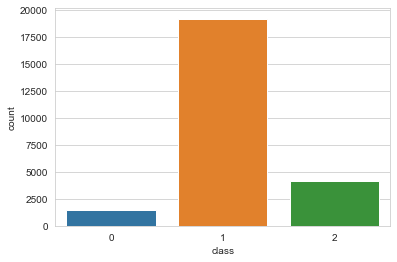

In [14]:
sns.countplot(train_df['class'],label="Count")

In [15]:
train_df['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

As the dataset is imblance, hate_speech tweets are very less, we will merge it with offensive_language. After that we will only have two clases, offensive (0) and no offensive (1).

In [16]:
train_df['class'] = train_df['class'].map( {0: 0, 1: 0,2:1} )

In [17]:
train_df['class'].value_counts()

0    20620
1     4163
Name: class, dtype: int64

## 2.4. Train Val Split

Divide up our training set to use 80% for training and 20% for validation.

In [18]:
train_df, valid_df = model_selection.train_test_split(
        train_df, test_size=0.2, random_state=42, stratify=train_df['class'].values
    )

In [19]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [20]:
train_df.head()

,tweet,class
0,They got David taking out the trash 128514 128...,1
1,RT Robin Thicke doing too much to get Paula ba...,0
2,RT hoes quick to say they can fuck somebody el...,0
3,RuinADessert Fairy Queen nomg gt I fucked Obam...,0
4,He run his mouth just like a bitch I had to cu...,0


In [21]:
train_df['class'].value_counts()

0    16496
1     3330
Name: class, dtype: int64

In [22]:
## Apply weights for imblance dataset 

In [23]:
classes_num = [16496, 3330]
normedWeights = [1 - (x / sum(classes_num)) for x in classes_num]
normedWeights = torch.FloatTensor(normedWeights).to(device)

Data looks like balance.

# 3. Pytorch Dataset Class

Now we will transform the tweets into the format that BERT can be trained on.

## 3.1. BERT Tokenizer

First of all we will convert tweet text into tokens and then these tokens will be mapped into their id's in the Bert Tokenizer Vocablury.

In [24]:
# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

### Required Formate

The Required Formate:
1. Convert Tweets to ID's
2. Truncate or Pad all tweets to a equal length.
3. Add special tokens to the start and end of each sentence.
4. Use "attention masks" to differentiate real tokens from padding tokens.

#### Tweets to IDs

The `tokenizer.encode_plus` will do:
1. Split the tweets into tokens.
2. Map the tokens to their IDs.
3. Add `[CLS]` and `[SEP]` tokens.
4. Truncate or Pad the tweets to equal length.


#### Special Tokens

**`[SEP]`**

At the end of every sentence, we need to append the special `[SEP]` token.

**`[CLS]`**

We have to append the special `[CLS]` token to the beginning of every tweet in classification.

#### Padding & Truncating

Truncate or Pad the tweets to same length, `MAX_LEN`.

Let's make a new column to detect how long the tweets are:

In [25]:
train_df['length'] = train_df['tweet'].str.len() #check Leanth of Each tweet

In [26]:
train_df['length'].describe()

count    19826.000000
mean        68.662968
std         35.744242
min          3.000000
25%         40.000000
50%         64.000000
75%         97.000000
max        493.000000
Name: length, dtype: float64

Maximum Length of tweet is 291, which is very long and as we see mean is 114. Let's see distribution of length.

<AxesSubplot:xlabel='length', ylabel='Density'>

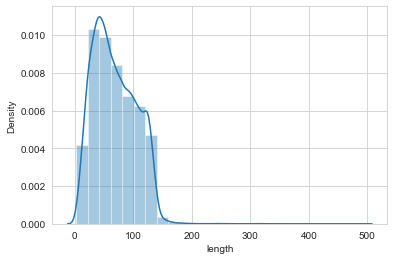

In [27]:
sns.distplot(train_df['length'],bins=25)

Let's see both classes length distribution seprately and Check we can see any trend.

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

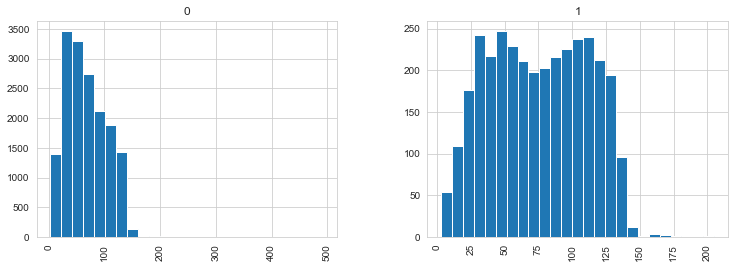

In [28]:
train_df.hist(column='length', by='class', bins=25,figsize=(12,4))

Hate speach tweets are shorter than the normal tweets. Given that, let's choose MAX_LEN = 128 and apply the padding.

####  Attention Masks

The attention masks are used to differentiate real tokens from padding tokens. 

## 3.5. Dataset Class


We will define our Dataset which be will used by Dataloader during loading the data in batches, and apply all the methods we define above.

In [29]:
class Bert_Dataset(Dataset):
    def __init__(self, tweets, labels, max_len, tokenizer):

        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, index):
        tweet = str(self.tweets[index]) # getting tweets
        
        # https://huggingface.co/transformers/main_classes/tokenizer.html
        encoded = self.tokenizer.encode_plus(
            tweet, # tweet to encode.
            None,  # text_pair Optional second sequence to be encoded
            add_special_tokens=True, # Add '[CLS]' and '[SEP]'
            max_length=self.max_len,  # Truncate all if longer than max len.
            pad_to_max_length=True,  # pad sentences shorter than max len
            truncation=True,
        )
        

        # before returning the values convert it torch tensors
        return {
            'ids': torch.tensor(encoded['input_ids']),
            'mask': torch.tensor(encoded['attention_mask']),
            'labels': torch.tensor(self.labels[index],)
        }

## 3.6. DataLoader

We will define a dataloader which will help us to load the data in batches instead of loading all the dataset in memory. 

In [30]:
# train Dataset
train_dataset = Bert_Dataset(
    tweets=train_df.tweet.values, labels=train_df['class'].values, max_len = MAX_LENGTH, tokenizer = tokenizer
)

# Train Data Loader
train_data_loader = DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=0
)

# Val dataset
valid_dataset = Bert_Dataset(
    tweets=valid_df.tweet.values, labels=valid_df['class'].values, max_len = MAX_LENGTH, tokenizer = tokenizer
)
# Val dataloader
valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=VALID_BATCH_SIZE, num_workers=0
    )

# 4. Classification Model

Now our Data is in the format as Bert Model needed, Let's create a BERT model.

## 4.1. Bert Model

Firstly we will modify the pre-trained BERT model to give outputs for classification, and  train the model on our dataset.

There are several BERT models, we will use "bert-base-uncased" which is the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

In [31]:
class BERT_Model(nn.Module):
    def __init__(self):
        
        super(BERT_Model, self).__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased') # Loading Pretrinaed Model
        self.out1 = nn.Linear(768, 2) # first linear layer
#         self.out2 = nn.Linear(500, 128) # Second linear Layer
#         self.out3 = nn.Linear(128, 2) # third linear layer
        self.drop_out = nn.Dropout(0.3) # Dropout
        self.relu = nn.ReLU() # activation

    def forward(self, ids, mask, token_type_ids):
        
        _, output_1= self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids) 
        x = self.drop_out(output_1)
        x = self.out1(x)
#         x = self.drop_out(x)
#         x = self.relu(x)
#         x = self.out2(x)
#         x = self.drop_out(x)
#         x = self.relu(x)
#         x = self.out3(x)
        return x

In [32]:
model = BERT_Model()
model.to(device)

BERT_Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

## 4.2. Optimizer & Learning Rate Scheduler

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [33]:
# AdamW is a class from the huggingface library
optimizer = AdamW(model.parameters(),
                  lr=3e-5, 
                  eps = 1e-8 
                )

In [34]:
# defining loss function
criterion = nn.CrossEntropyLoss(weight=normedWeights)
print("Loss function Used : Cross Entropy Loss")

Loss function Used : Cross Entropy Loss


Defining the scheduler to adjust the learning rate during training.

In [35]:
# Total number of training steps
total_steps = len(train_data_loader) * N_EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Accuracy Curve

In [36]:
# this function will plot the accuracy and loss graph of training and validation
def plot_loss_and_accuracy_curves(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    ax[0].plot(history['train_accuracy'], color='royalblue', label='Train Accuracy')
    ax[0].plot(history['val_accuracy'], color='darkred', label='Validation Accuracy')

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].legend()

    ax[1].plot(history['train_loss'], color='royalblue', label='Train Loss')
    ax[1].plot(history['val_loss'], color='darkred', label='Validation Loss')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Cross Entropy Loss')
    ax[1].set_title('Training and Validation Losses')
    ax[1].legend()
    plt.show()

## 4.4. Training Loop

Working of the Training Function

Training:

- Unpack the data
- Load data into Device
- Clear out the gradients 
- Pass inputs to Model (forward pass)
- Calculate the Loss
- Backward pass (backpropagation)
- Update the parameters of the model using optimizer.step()

Evalution:

- Unpack the data
- Load data into Device
- Pass inputs to Model (forward pass)
- Compute loss on validation data  

In [37]:
# this function will train our mode and only save best model with high validation accuracy
def train(model, criterion, optimizer, train_loader, validation_loader, model_save_name, epochs=5, plot_curves=True,
          history=None, lr_scheduler=None):
    # create the Models folder if it's not exit
    Path(models_path).mkdir(parents=True, exist_ok=True)
    # loading the model into device i.e cpu or gpu
    model.to(device)
    # making a copy of model
    best_model = copy.deepcopy(model)
    # Defining the history
    if history is None:
        history = {'train_loss': [], 'train_accuracy': [], 'val_accuracy': [], 'val_loss':[],
                   'epochs': 0, 'best_val_accuracy': -np.inf}

    # defining the variable we will use during the training
    best_val_accuracy = history['best_val_accuracy']

    total_epochs = epochs

    for epoch in range(0, total_epochs):  # loop over the dataset multiple times

        train_loss = 0.0
        val_loss = 0.0

        train_accuracy = 0.0
        val_accuracy = 0.0

        correct = 0
        # setting the model in training mode
        model.train()
        # defining the tqdm for displaying the results after every epoch
        outer = tqdm(total=len(train_loader.dataset), desc='Train Epoch: %s / %s' % (epoch + 1, total_epochs),
                     position=0, leave=True)

        # iterate over train loader
        for data in train_loader:
            
            ids = data["ids"]
            mask = data["mask"]
            labels = data["labels"]
            # loading the inputs and outputs into device
            ids = ids.to(device)
            mask = mask.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(ids=ids, mask=mask, token_type_ids=None)
            loss = criterion(outputs, labels)  # ----> compute loss

            loss.backward()  # ----> backward pass
            
            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()  # ----> weights update
            # learning scheduler step
            lr_scheduler.step()
            # total train loss
            train_loss += loss.item()
            # getting the predicted classes
            _, predicted = torch.max(outputs.data, 1)
            # comparing the predicted classes with actual classes
            correct += (predicted == labels).sum().item()
            # update tqdm
            outer.update(len(ids))
        outer.close()
        # train accuracy and loss
        train_accuracy = correct / len(train_loader.dataset)
        train_loss = train_loss / len(train_loader)

        # Val loss and accuracy
        with torch.no_grad():
            correct = 0
            # setting model to Evaluation
            model.eval()

            for data in validation_loader:
                
                ids = data["ids"]
                mask = data["mask"]
                labels = data["labels"]
                # loading the inputs and outputs into device
                ids = ids.to(device)
                mask = mask.to(device)
                labels = labels.to(device)

                # forward + backward + optimize
                outputs = model(ids=ids, mask=mask, token_type_ids=None)
                
                loss = criterion(outputs, labels)  # ----> compute loss
                val_loss += loss.item()
                

                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / len(validation_loader.dataset)
        val_loss = val_loss / len(validation_loader)

        # print statics using tqdm
        epoch_log = tqdm(total=0, bar_format='{desc}', position=0, leave=True)
        epoch_log.set_description_str(
            'LR: {} | Train Loss: {:.6f} | Validation Loss: {:.6f} | '
            'Train Accuracy: {:.2f} | Validation Accuracy: {:.2f}'.format(
                lr_scheduler.get_lr(), train_loss, val_loss , train_accuracy, val_accuracy))
        epoch_log.close()

        # saving best model params for minimum validation loss during all epochs
        if val_accuracy >= best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model.load_state_dict(model.state_dict())
            torch.save(best_model, models_path + model_save_name)

        # update history
        history['epochs'] += 1
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)
        history['best_val_accuracy'] = best_val_accuracy

    # plot graph of accuracy
    if plot_curves:
        plot_loss_and_accuracy_curves(history)

    return history, best_model

Train Epoch: 1 / 3: 100%|████████████████████████████████████████████████████████| 19826/19826 [09:02<00:00, 36.52it/s]
LR: [1.9999999999999998e-05] | Train Loss: 0.215317 | Validation Loss: 0.161204 | Train Accuracy: 0.94 | Validation Accuracy: 0.96
Train Epoch: 2 / 3: 100%|████████████████████████████████████████████████████████| 19826/19826 [09:06<00:00, 36.29it/s]
LR: [9.999999999999999e-06] | Train Loss: 0.126475 | Validation Loss: 0.224758 | Train Accuracy: 0.98 | Validation Accuracy: 0.96
Train Epoch: 3 / 3: 100%|████████████████████████████████████████████████████████| 19826/19826 [09:05<00:00, 36.32it/s]
LR: [0.0] | Train Loss: 0.075532 | Validation Loss: 0.273599 | Train Accuracy: 0.99 | Validation Accuracy: 0.96


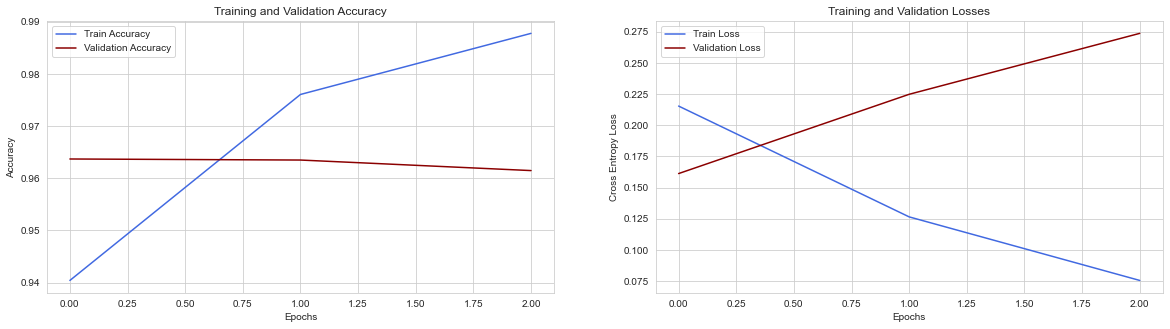

In [38]:
# start training
history, best_model = train(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            train_loader=train_data_loader,
                            validation_loader=valid_data_loader,
                            model_save_name=model_name,
                            epochs=N_EPOCHS,
                            lr_scheduler=scheduler)

# 5. Confusion matrix and Classification Report

For the Evaluation we will Plot Confusion Matrix and Classification Report on our Validation Data.

In [39]:
y_pred = []
y_true = []
with torch.no_grad():
    best_model.eval()

    for data in valid_data_loader: # Iterate over Dataloader
                
        ids = data["ids"]
        mask = data["mask"]
        labels = data["labels"]
        # loading the inputs and outputs into device
        ids = ids.to(device)
        mask = mask.to(device)

        # forward + backward + optimize
        outputs = best_model(ids=ids, mask=mask, token_type_ids=None)
        # get the prediction class id
        _, predicted = torch.max(outputs.data, 1)
        # append the predicted and label into list
        y_pred.append(predicted.cpu().detach().numpy())
        y_true.append(labels)

In [40]:
y_pred = np.concatenate( y_pred, axis=0)

In [41]:
y = np.concatenate(y_true, axis=0)

#### Confusion Matrix

In [42]:
cm = confusion_matrix(y,y_pred)

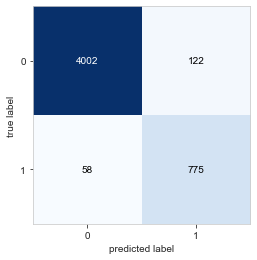

In [43]:
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

#### Classification Report

In [44]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4124
           1       0.86      0.93      0.90       833

    accuracy                           0.96      4957
   macro avg       0.92      0.95      0.94      4957
weighted avg       0.97      0.96      0.96      4957

